# Basic tutorial for using the mdestimates package

In this tutorial, we will show how to estimate the errors (measured in the primal energy norm) of numerical solutions for flow problems including an arbitrary number of fractures in PorePy. The estimates are valid for all current available numerical methods (TPFA, MPFA, RT0-P0, and MVEM-P0) and are restricted to simplicial grids (i.e., triangles and tetrahedra).

First, some notation. We consider a fracture network composed by $m$ subdomains $\Omega_i$ of different dimensionality. We will identify them with a global index $i$ such that $i \in I$, $I = [1, 2, \ldots, m]$. Sudbomains one dimension apart are coupled via interfaces $\Gamma_{ij}$, where $i$ denotes the lower-, and $j$ the higher-dimensional adjacent subdomain. Finally, we will use $\check{S}_i$, defined as the set of all neighboring subdomains one-dimension lower than $\Omega_i$. In an abuse of notation, we will also use $\Omega_i$ and $\Gamma_{ji}$ to denote the subdomain and mortar grids, respectively.

The error for the whole network is given most generally by an upper bound of the type

$$
||| \mathfrak{p} - \tilde{\mathfrak{p}}_h ||| \leq \mathcal{M}_{\mathrm{LC}}(\tilde{\mathfrak{p}}_h,\mathfrak{u}_h;\mathfrak{f}),
$$

where $\mathfrak{p}$ and $\tilde{\mathfrak{p}}_h$ are the mixed-dimensional exact and reconstructed pressures, $\mathfrak{u}_h$ is the mixed-dimensional flux, and $\mathfrak{f}$ is the mixed-dimensional source term. The quantitity $\mathcal{M}_{\mathrm{LC}}$ is known as the computable majorant, and depends only on the approximated solution and the source term. 

It can be shown that, for locally-mass conservative schemes, the majorant is given by:

$$
\mathcal{M}_{\mathrm{LC}}^2 = \sum_{i\in I}  \left(\sum_{K \in \Omega_i} || \mathcal{K}_i^{-1/2}\mathbf{u}_{i,h} + \mathcal{K}_i^{1/2}\nabla \tilde{p}_{i,h} ||^2_K  + \sum_{j \in \check{S}_i} \sum_{K \in \Gamma_{ji}} ||\kappa_{ji}^{-1/2} \lambda_{ji,h} + \kappa_{ji}^{1/2} \left(\tilde{p}_{j,h} - \mathrm{tr} \tilde{p}_{i, h} \right) ||^2_K \right),
$$

where $\tilde{p}_h$ is the reconstructed pressure (obtained from the numerical approximation), $\mathbf{u}_h$ is the approximated tangential flux, and $\lambda_h$ is the approximated mortar flux. Moreover, $\mathcal{K}$ and $\kappa$ refer to the usual tangential and normal permeabilities.

For specific details and complete proofs we refer to https://arxiv.org/abs/2101.08331.

In [1]:
# Import modules
import porepy as pp
import numpy as np
import mdestimates as mde
import scipy.sparse as sps

## Assemble and solve a flow problem in PorePy

In [2]:
def create_grid_bucket(mesh_args):
    """
    Creates the 2D mixed-dimensional fracture network as in:
        https://github.com/keileg/porepy_intro/blob/master/MixedDimensionalFlow.ipynb

    Parameters
    ----------
    mesh_args: Dict
        Dictionary containing the mesh targets, i.e.:
        {'mesh_size_bound': target_h_bound, 'mesh_size_frac': target_h_fracture}

    Returns
    -------
    grid_bucket: pp.GridBucket
        Containing the mixed-dimensional grids
    """
    
    # Define start and endpoints of the fractures.  
    pts = np.array([[0.3, 0.7, 0.8, 0.2],
                    [0.2, 0.8, 0.2, 0.8]])
    
    # Connection between the points
    connections = np.array([[0, 2],
                            [1, 3]])
    
    # Set the domain to the unit square, specified as a dictionary
    domain = {'xmin': 0, 'xmax': 1, 'ymin': 0, 'ymax': 1}

    # Define a 2d fracture network 
    network_2d = pp.FractureNetwork2d(pts, connections, domain)
    
    # Construct the mesh to obtain a mixed-dimensional PorePy mesh
    grid_bucket = network_2d.mesh(mesh_args)
    
    return grid_bucket


def assign_parameters(grid_bucket):
    """
    Assigns parameters for the flow problem. 
    
    Parameters
    ----------
    grid_bucket: pp.GridBucket
        Containing the mixed-dimensional grid
    """

    # Assign subdomain parameters
    for g, d in gb:

        # Permeability assignment
        if g.dim == 2:
            kxx = np.ones(g.num_cells)
        else:
            kxx = 1e-4 * np.ones(g.num_cells)
        perm = pp.SecondOrderTensor(kxx=kxx)
        specified_parameters = {'second_order_tensor': perm}

        # Add boundary conditions: Linear pressure drop from left (p=1) to right (p=0), the rest no flow.
        if g.dim == 2:
            
            left = np.where(np.abs(g.face_centers[0]) < 1e-5)[0]
            right = np.where(np.abs(g.face_centers[0] - 1) < 1e-5)[0]

            # Define BoundaryCondition object
            bc_faces = np.hstack((left, right))
            bc_type = bc_faces.size * ['dir']
            bc = pp.BoundaryCondition(g, faces=bc_faces, cond=bc_type)

            # Register the assigned value
            specified_parameters['bc'] = bc

            # Also set the values - specified as vector of size g.num_faces
            bc_values = np.zeros(g.num_faces)
            bc_values[left] = 1
            bc_values[right] = 0
            specified_parameters['bc_values'] = bc_values

        # Initialize subdomain data dictionary
        pp.initialize_default_data(g, d, "flow", specified_parameters)

    # Assing interface parameters 
    for e, d in gb.edges():
        # Set the normal diffusivity
        data = {"normal_diffusivity": 1e1}
        
        # Initialize edge data dictionaries
        mg = d["mortar_grid"]
        pp.initialize_data(mg, d, "flow", data)
        
        
def assign_discretization(grid_bucket, numerical_method):
    """
    Assign variables and perform discretization 
    
    Parameters
    ----------
    grid_bucket: pp.GridBucket
        Containing the mixed-dimensional grid
    """
      
    # Declare subdomain discretization
    if numerical_method == 'TPFA':
        subdomain_discretization = pp.Tpfa(keyword="flow")
    elif numerical_method == 'MPFA':
        subdomain_discretization = pp.Mpfa(keyword="flow")
    elif numerical_method == 'RT0':
        subdomain_discretization = pp.RT0(keyword="flow")
    elif numerical_method == 'MVEM':
        subdomain_discretization = pp.MVEM(keyword="flow")
    else:
        raise ValueError('Method unrecognized!')
        
    # Declare interface discretization
    edge_discretization = pp.RobinCoupling("flow", subdomain_discretization, subdomain_discretization)
    
    # Use standard keywords
    subdomain_variable = "pressure"
    subdomain_operator_keyword = "diffusion"
    edge_variable = "mortar_flux"
    coupling_operator_keyword = 'interface_diffusion'
    
    # Discretize subdomains
    for g, d in gb:
        if numerical_method in ['TPFA', 'MPFA']:
            d[pp.PRIMARY_VARIABLES] = {subdomain_variable: {"cells": 1, "faces": 0}}
        else:
            d[pp.PRIMARY_VARIABLES] = {subdomain_variable: {"cells": 1, "faces": 1}}
        d[pp.DISCRETIZATION] = {subdomain_variable: {subdomain_operator_keyword: subdomain_discretization}}    

    # Discretize interfaces
    for e, d in gb.edges():
        g_secondary, g_primary = gb.nodes_of_edge(e)
        d[pp.PRIMARY_VARIABLES] = {edge_variable: {"cells": 1}}
        d[pp.COUPLING_DISCRETIZATION] = {
            coupling_operator_keyword: {
                g_secondary: (subdomain_variable, subdomain_operator_keyword),
                g_primary: (subdomain_variable, subdomain_operator_keyword),
                e: (edge_variable, edge_discretization),
            }
        }

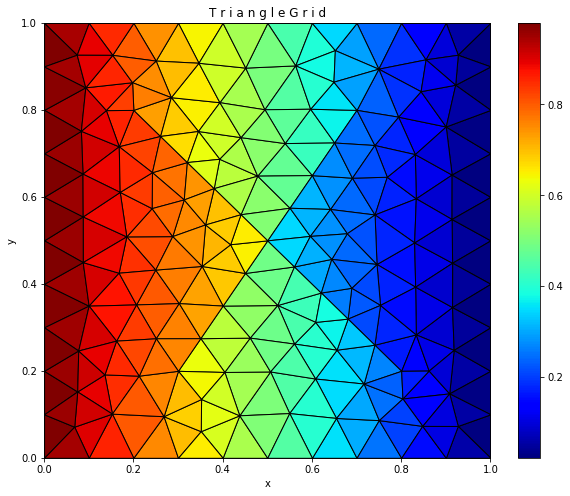

In [3]:
# Create grid bucket
target_h_bound = 0.1  # far-field mesh size for the matrix
target_h_fracture = 0.1 # mesh size for the fracture and its vicinity
mesh_args = {'mesh_size_bound': target_h_bound, 'mesh_size_frac': target_h_fracture}
gb = create_grid_bucket(mesh_args)

# Assign parameters
assign_parameters(gb)

# Assign variables and discretization
numerical_method = 'MPFA' # Valid options: 'TPFA', 'MPFA', 'RT0', 'MVEM'
assign_discretization(gb, numerical_method)

# Assemble and solve
assembler = pp.Assembler(gb)
assembler.discretize()
A, b = assembler.assemble_matrix_rhs()
sol = sps.linalg.spsolve(A, b)
assembler.distribute_variable(sol)

# Make sure that pressures and fluxes are correctly stored in d[pp.STATE]
for g, d in gb:
    discr = d[pp.DISCRETIZATION]["pressure"]["diffusion"]
    pressure = discr.extract_pressure(g, d[pp.STATE]["pressure"], d).copy()
    flux = discr.extract_flux(g, d[pp.STATE]["pressure"], d).copy()
    d[pp.STATE]["pressure"] = pressure
    d[pp.STATE]["flux"] = flux

# Plot pressure solution for the matrix
g_2d = gb.grids_of_dimension(2)[0]
d_2d = gb.node_props(g_2d)
pp.plot_grid(g_2d, d_2d[pp.STATE]["pressure"], figsize=(10, 8), plot_2d=True)

## Estimate the errors

In [4]:
# First, create the error estimates object
estimates = mde.ErrorEstimate(gb)

# Now, perform the actual estimation of the error
estimates.estimate_error()

# It is convenient to transfer the errors to d[pp.STATE]
estimates.transfer_error_to_state()

# We can print a summary of the errors
estimates.print_summary(scaled=True)

# Now, for example, we can plot the error associatebd to the matrix domain
pp.plot_grid(g_2d, d_2d[pp.STATE]["diffusive_error"], figsize=(10, 8), plot_2d=True)

Performing velocity reconstruction...✓
Performing pressure reconstruction...✓
Computing upper bounds...

QuadpyError: Wrong return value shape (268, 1). Expected (..., 268, 6).

**TIP**: Refine the mesh and see how the errors decrease :)